Tema 2 - AI2


Nume: Văideanu Renata - Georgia

Grupa: 342 C4


Importul bibliotecilor necesare

In [2]:
import os
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
from sklearn.decomposition import PCA
from skimage import exposure
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
import glob
import cv2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog


In [3]:
def readFruitsInput(fruits, data_type, dim, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    path = os.path.join(path2, data_type)
    for i, f in enumerate(fruits):
        p = os.path.join(path, f)
        j = 0
        for image_path in glob.glob(os.path.join(p, "*.jpg")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
            images.append(image)
            labels.append(i)
            j += 1
        if print_n:
            print(f"There are {j} {data_type.upper()} images of {fruits[i].upper()}")
    # Conversie la array-uri NumPy
    images = np.array(images, dtype='float32')
    labels = np.array(labels)
    return images, labels


path2 = r"F:\Facultate\Anul 4\Semestrul 1\IA2\Teme\Tema1\fruits-360"
fruits = os.listdir(os.path.join(path2, "Training"))



In [3]:

d = 100
# Citirea datelor în format aplatizat
x_train_fruits, y_train_fruits = readFruitsInput(fruits, 'Training', dim  = d, print_n=True)
x_test_fruits, y_test_fruits = readFruitsInput(fruits, 'Test', dim = d, print_n=True)

# Verificarea formelor datelor
print("Fruit Training data shape:", x_train_fruits.shape, y_train_fruits.shape)
print("Fruit Test data shape:", x_test_fruits.shape, y_test_fruits.shape)


There are 473 TRAINING images of APPLE 6
There are 492 TRAINING images of APPLE BRAEBURN 1
There are 444 TRAINING images of APPLE CRIMSON SNOW 1
There are 480 TRAINING images of APPLE GOLDEN 1
There are 492 TRAINING images of APPLE GOLDEN 2
There are 481 TRAINING images of APPLE GOLDEN 3
There are 492 TRAINING images of APPLE GRANNY SMITH 1
There are 702 TRAINING images of APPLE HIT 1
There are 456 TRAINING images of APPLE PINK LADY 1
There are 492 TRAINING images of APPLE RED 1
There are 492 TRAINING images of APPLE RED 2
There are 429 TRAINING images of APPLE RED 3
There are 490 TRAINING images of APPLE RED DELICIOUS 1
There are 492 TRAINING images of APPLE RED YELLOW 1
There are 672 TRAINING images of APPLE RED YELLOW 2
There are 492 TRAINING images of APRICOT 1
There are 427 TRAINING images of AVOCADO 1
There are 491 TRAINING images of AVOCADO RIPE 1
There are 490 TRAINING images of BANANA 1
There are 450 TRAINING images of BANANA LADY FINGER 1
There are 490 TRAINING images of BANA

In [4]:
# Încărcarea datasetului Fashion-MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Normalizarea datelor Fashion-MNIST
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0


# Cerinta 0. Reimplementarea algoritmilor din prima etapa

### 1. Extragerea de atribute folosind PCA (Principal Component Analysis)

In [5]:
no_components = 20
pca = PCA(no_components)

FASHION

In [6]:
x_train_fashion_flat = x_train_fashion.reshape(x_train_fashion.shape[0], -1)
x_test_fashion_flat = x_test_fashion.reshape(x_test_fashion.shape[0], -1)

x_train_pca_fashion = pca.fit_transform(x_train_fashion_flat)
x_test_pca_fashion = pca.transform(x_test_fashion_flat)

x_train_reconstructed_fashion = pca.inverse_transform(x_train_pca_fashion)

print(f"Numărul de componente principale selectate: {pca.n_components_}")

print(np.cumsum(pca.explained_variance_ratio_[:20]))


Numărul de componente principale selectate: 20
[0.29039228 0.46794538 0.5281376  0.57771188 0.61618843 0.65079612
 0.67421303 0.69326717 0.7067656  0.71990827 0.72983702 0.73896957
 0.7466275  0.75322454 0.75930303 0.76520124 0.77072055 0.77596531
 0.78054447 0.78509882]


FRUITS

In [7]:
# Aplatizăm datele pentru a putea aplica PCA
x_train_fruits_flat = x_train_fruits.reshape(x_train_fruits.shape[0], -1)
x_test_fruits_flat = x_test_fruits.reshape(x_test_fruits.shape[0], -1)

# Aplicăm PCA pe datele de antrenament
x_train_pca_fruits = pca.fit_transform(x_train_fruits_flat)
x_test_pca_fruits = pca.fit_transform(x_test_fruits_flat)

# Reconstruim imaginile folosind PCA
x_train_reconstructed = pca.inverse_transform(x_train_pca_fruits)

# Afișăm informații despre PCA
print(f"Numărul de componente principale selectate pentru Fruits-360: {x_train_pca_fruits.shape[1]}")

print(np.cumsum(pca.explained_variance_ratio_[:20]))

Numărul de componente principale selectate pentru Fruits-360: 20
[0.30149928 0.42006263 0.5298177  0.57509357 0.61873525 0.649147
 0.67432094 0.6934641  0.7089935  0.724376   0.73847926 0.750266
 0.75981545 0.7687505  0.7757854  0.78231984 0.7882888  0.79399925
 0.79937094 0.8044879 ]


### 2. Extragerea de atribute folosind HOG (Histogram of Oriented Gradients)

In [8]:
# Definirea funcției pentru extragerea caracteristicilor HOG
def extract_hog_features_fruits(images):
    hog_features = []
    for image in images:
        # Reconstruim imaginea dacă este aplatizată
        # Convertim imaginea la grayscale
        gray_image = color.rgb2gray(image)
        
        # Aplicăm HOG pentru extragerea caracteristicilor
        hog_feature = hog(
            gray_image, 
            pixels_per_cell=(16, 16),  # Poți ajusta acest parametru
            cells_per_block=(2, 2),   # La fel și acest parametru
            block_norm='L2-Hys', 
            visualize=False
        )
        hog_features.append(hog_feature)
    
    # Returnăm caracteristicile HOG ca array NumPy
    return np.array(hog_features)


In [9]:
# Extragem caracteristicile HOG pentru seturile de antrenament și test
x_train_hog_fruits = extract_hog_features_fruits(x_train_fruits)
x_test_hog_fruits = extract_hog_features_fruits(x_test_fruits)

x_train_hog_fruits_flat = x_train_hog_fruits.reshape(x_train_hog_fruits.shape[0], -1)
x_test_hog_fruits_flat = x_test_hog_fruits.reshape(x_test_hog_fruits.shape[0], -1)

# Afișăm dimensiunea vectorilor HOG pentru setul de antrenament
print(f"Dimensiunea vectorilor HOG pentru imaginile de antrenament: {x_train_hog_fruits.shape[1]}")


Dimensiunea vectorilor HOG pentru imaginile de antrenament: 900


In [10]:
# Funcția pentru extragerea caracteristicilor HOG
def extract_hog_features_fashion(images):
    hog_features = []
    for img in images:
        features = hog(img, 
                    pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys', 
                    visualize=False)
        hog_features.append(features)

    return np.array(hog_features)

In [11]:
x_train_hog_fashion = extract_hog_features_fashion(x_train_fashion)
x_test_hog_fashion = extract_hog_features_fashion(x_test_fashion)

# Afișarea dimensiunii vectorilor HOG pentru imaginile de antrenament
print(f"Dimensiunea vectorilor HOG pentru imaginile de antrenament: {x_train_hog_fashion.shape[1]}")


Dimensiunea vectorilor HOG pentru imaginile de antrenament: 144


In [12]:
# Importăm librăriile necesare
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
import matplotlib.pyplot as plt
from skimage.feature import hog

train_combined_features_fruits = np.hstack([x_train_pca_fruits, x_train_hog_fruits])
test_combined_features_fruits = np.hstack([x_test_pca_fruits, x_test_hog_fruits])

train_combined_features_fashion = np.hstack([x_train_pca_fashion, x_train_hog_fashion])
test_combined_features_fashion = np.hstack([x_test_pca_fashion, x_test_hog_fashion])



In [13]:
# Standardizare
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_combined_features_fruits)
x_test_scaled = scaler.transform(test_combined_features_fruits)

percentile_selector = SelectPercentile(score_func=f_classif, percentile=10)
x_train_selectedP = percentile_selector.fit_transform(x_train_scaled, y_train_fruits)
x_test_selectedP = percentile_selector.transform(x_test_scaled)

# Afișare dimensiuni
print(f"Original feature shape for training: {train_combined_features_fruits.shape}")
print(f"Select Percentile shape for training: {x_train_selectedP.shape}")

print(f"Original feature shape for test: {test_combined_features_fruits.shape}")
print(f"Select Percentile shape for test: {x_test_selectedP.shape}")


x_train_fruits_stand = x_train_selectedP
x_test_fruits_stand = x_test_selectedP


Original feature shape for training: (70491, 920)
Select Percentile shape for training: (70491, 92)
Original feature shape for test: (23619, 920)
Select Percentile shape for test: (23619, 92)


In [14]:
# Standardizare
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_combined_features_fashion)
x_test_scaled = scaler.transform(test_combined_features_fashion)

percentile_selector = SelectPercentile(score_func=f_classif, percentile=30)
x_train_selectedP = percentile_selector.fit_transform(x_train_scaled, y_train_fashion)
x_test_selectedP = percentile_selector.transform(x_test_scaled)

# Afișare dimensiuni
print(f"Original feature shape for training: {train_combined_features_fashion.shape}")
print(f"Select Percentile shape for training: {x_train_selectedP.shape}")

print(f"Original feature shape for test: {test_combined_features_fashion.shape}")
print(f"Select Percentile shape for test: {x_test_selectedP.shape}")

x_train_fashion_stand = x_train_selectedP
x_test_fashion_stand = x_test_selectedP


Original feature shape for training: (60000, 164)
Select Percentile shape for training: (60000, 49)
Original feature shape for test: (10000, 164)
Select Percentile shape for test: (10000, 49)


# Cerinta 1. MLP pe atributele extrase în etapa 1

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs):
    plt.figure(figsize=(14, 7))

    # Subplot pentru Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='purple')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='pink')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)

    # Subplot pentru Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='purple')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='pink')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()
    plt.grid(True)

    # Ajustarea aspectului și afișarea
    plt.tight_layout()
    plt.show()

Epoch [1/80], Train Loss: 4.6524, Train Accuracy: 5.58%, Test Loss: 4.2116, Test Accuracy: 6.86%
Epoch [2/80], Train Loss: 3.6695, Train Accuracy: 15.62%, Test Loss: 3.5263, Test Accuracy: 19.49%
Epoch [3/80], Train Loss: 3.0574, Train Accuracy: 30.39%, Test Loss: 3.1101, Test Accuracy: 31.60%
Epoch [4/80], Train Loss: 2.6021, Train Accuracy: 42.47%, Test Loss: 2.7697, Test Accuracy: 39.72%
Epoch [5/80], Train Loss: 2.2247, Train Accuracy: 50.80%, Test Loss: 2.4937, Test Accuracy: 45.27%
Epoch [6/80], Train Loss: 1.9192, Train Accuracy: 57.27%, Test Loss: 2.2830, Test Accuracy: 48.47%
Epoch [7/80], Train Loss: 1.6749, Train Accuracy: 62.50%, Test Loss: 2.1188, Test Accuracy: 51.05%
Epoch [8/80], Train Loss: 1.4786, Train Accuracy: 66.77%, Test Loss: 1.9957, Test Accuracy: 52.97%
Epoch [9/80], Train Loss: 1.3189, Train Accuracy: 70.47%, Test Loss: 1.9024, Test Accuracy: 54.43%
Epoch [10/80], Train Loss: 1.1863, Train Accuracy: 73.37%, Test Loss: 1.8324, Test Accuracy: 55.56%
Epoch [11/8

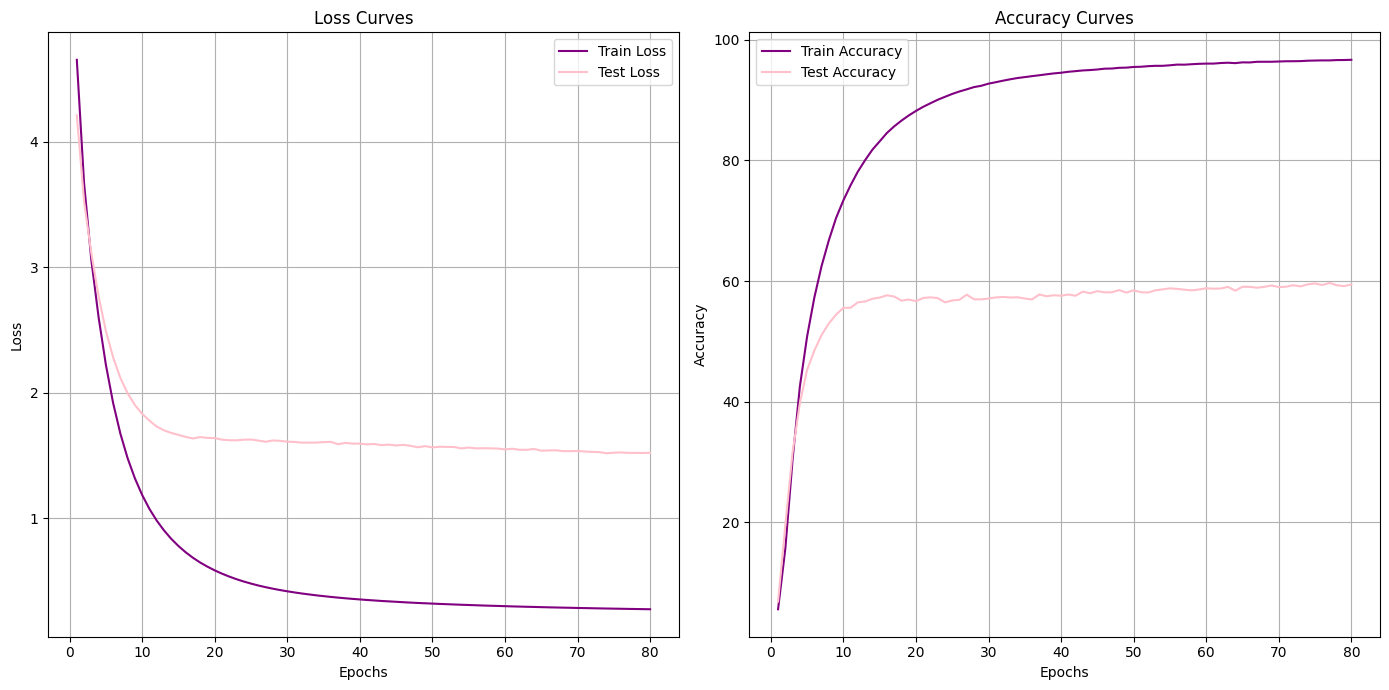

In [69]:
scaler = StandardScaler()
x_train_fruits_stand = scaler.fit_transform(x_train_fruits_stand)
x_test_fruits_stand = scaler.transform(x_test_fruits_stand)

input_size = x_train_fruits_stand.shape[1] # Actualizăm input_size cu dimensiunea corectă

# Optimize hyperparameters

output_size = 141
batch_size = 128
learning_rate = 5e-5
num_epochs = 80

# Device configuration

device = torch.device("cuda")

# Convert data to tensors

x_train_tensor_fruits = torch.tensor(x_train_fruits_stand).float()
y_train_tensor_fruits = torch.tensor(y_train_fruits).long()
x_test_tensor_fruits = torch.tensor(x_test_fruits_stand).float()
y_test_tensor_fruits = torch.tensor(y_test_fruits).long()

train_dataset = TensorDataset(x_train_tensor_fruits, y_train_tensor_fruits)
test_dataset = TensorDataset(x_test_tensor_fruits, y_test_tensor_fruits)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Initialize the model, loss function, and optimizer
model = MLP(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=4e-3)

# Initialize lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model (inputs)
        loss = criterion (outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100* correct_train / total_train)

    # Evaluation Phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion (outputs, targets)
            # Statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')
    
# Final Test Accuracy
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

final_test_accuracy = 100 * correct_test / total_test
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

# Plot the training and testing metrics
print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

Epoch [1/80], Train Loss: 0.9878, Train Accuracy: 64.87%, Test Loss: 0.6519, Test Accuracy: 75.31%
Epoch [2/80], Train Loss: 0.6028, Train Accuracy: 76.63%, Test Loss: 0.5824, Test Accuracy: 77.42%
Epoch [3/80], Train Loss: 0.5531, Train Accuracy: 78.53%, Test Loss: 0.5556, Test Accuracy: 78.98%
Epoch [4/80], Train Loss: 0.5243, Train Accuracy: 79.81%, Test Loss: 0.5282, Test Accuracy: 79.89%
Epoch [5/80], Train Loss: 0.5038, Train Accuracy: 80.63%, Test Loss: 0.5246, Test Accuracy: 80.14%
Epoch [6/80], Train Loss: 0.4902, Train Accuracy: 81.17%, Test Loss: 0.5157, Test Accuracy: 80.22%
Epoch [7/80], Train Loss: 0.4791, Train Accuracy: 81.59%, Test Loss: 0.4962, Test Accuracy: 81.20%
Epoch [8/80], Train Loss: 0.4701, Train Accuracy: 81.80%, Test Loss: 0.4914, Test Accuracy: 81.30%
Epoch [9/80], Train Loss: 0.4625, Train Accuracy: 82.20%, Test Loss: 0.4870, Test Accuracy: 81.58%
Epoch [10/80], Train Loss: 0.4560, Train Accuracy: 82.55%, Test Loss: 0.4767, Test Accuracy: 81.94%
Epoch [11

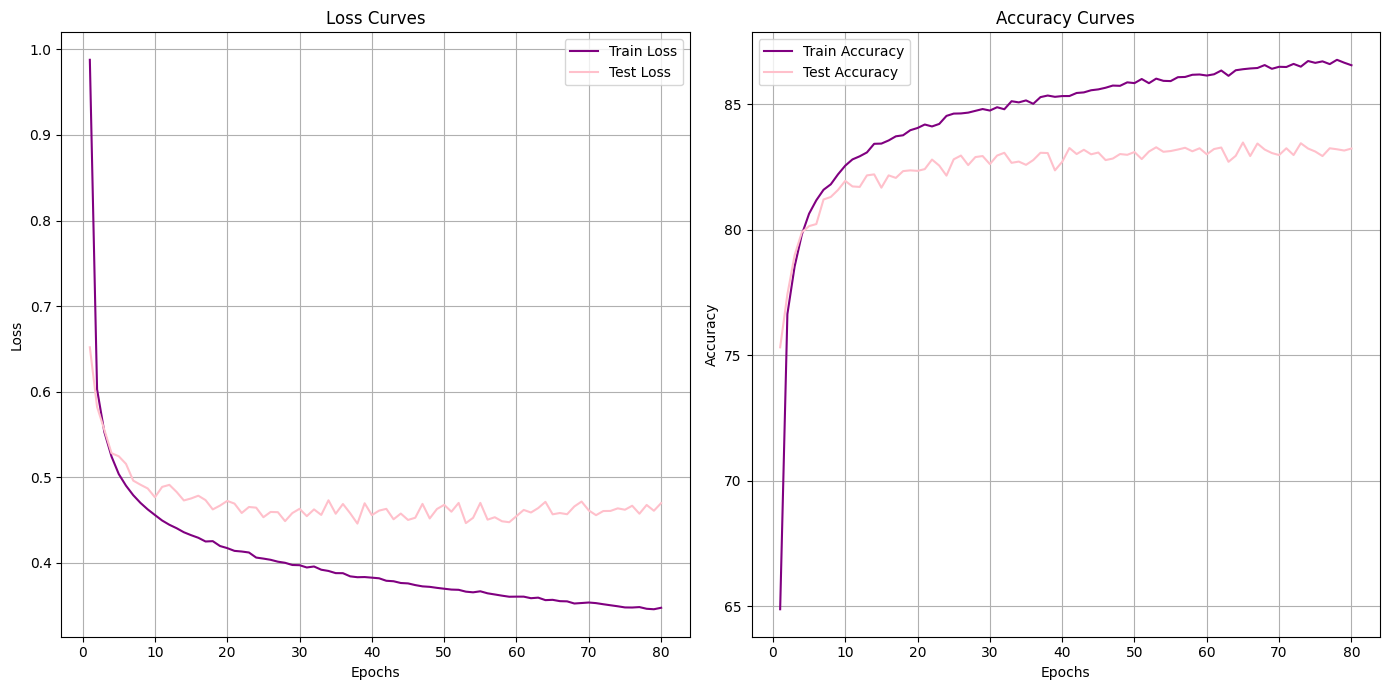

In [23]:
scaler = StandardScaler()
x_train_fashion_stand = scaler.fit_transform(x_train_fashion_stand)
x_test_fashion_stand = scaler.transform(x_test_fashion_stand)

# Dimensiunea reală a datelor după SelectPercentile
input_size = x_train_fashion_stand.shape[1]  # Actualizăm input_size cu dimensiunea corectă

# Hyperparameters
output_size = 10  # FashionMNIST has 10 classes
batch_size = 64
learning_rate = 1e-5
num_epochs = 80

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to tensors
x_train_tensor = torch.tensor(x_train_fashion_stand).float()
y_train_tensor = torch.tensor(y_train_fashion).long()
x_test_tensor = torch.tensor(x_test_fashion_stand).float()
y_test_tensor = torch.tensor(y_test_fashion).long()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=12)

# Initialize the model, loss function, and optimizer
model = MLP(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model (inputs)
        loss = criterion (outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100* correct_train / total_train)

    # Evaluation Phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion (outputs, targets)
            # Statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')
    
# Final Test Accuracy
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

final_test_accuracy = 100 * correct_test / total_test
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

# Plot the training and testing metrics
print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

# Cerinta 2


Epoch [1/80], Train Loss: 1.8770, Train Accuracy: 49.85%, Test Loss: 1.4440, Test Accuracy: 61.35%
Epoch [2/80], Train Loss: 1.1624, Train Accuracy: 66.42%, Test Loss: 0.9714, Test Accuracy: 70.70%
Epoch [3/80], Train Loss: 0.8558, Train Accuracy: 72.72%, Test Loss: 0.7834, Test Accuracy: 74.13%
Epoch [4/80], Train Loss: 0.7228, Train Accuracy: 75.32%, Test Loss: 0.6932, Test Accuracy: 76.02%
Epoch [5/80], Train Loss: 0.6501, Train Accuracy: 76.93%, Test Loss: 0.6379, Test Accuracy: 77.29%
Epoch [6/80], Train Loss: 0.6024, Train Accuracy: 78.26%, Test Loss: 0.6013, Test Accuracy: 78.18%
Epoch [7/80], Train Loss: 0.5682, Train Accuracy: 79.47%, Test Loss: 0.5753, Test Accuracy: 79.17%
Epoch [8/80], Train Loss: 0.5421, Train Accuracy: 80.37%, Test Loss: 0.5510, Test Accuracy: 79.86%
Epoch [9/80], Train Loss: 0.5214, Train Accuracy: 81.12%, Test Loss: 0.5348, Test Accuracy: 80.63%
Epoch [10/80], Train Loss: 0.5043, Train Accuracy: 81.77%, Test Loss: 0.5216, Test Accuracy: 81.05%
Epoch [11

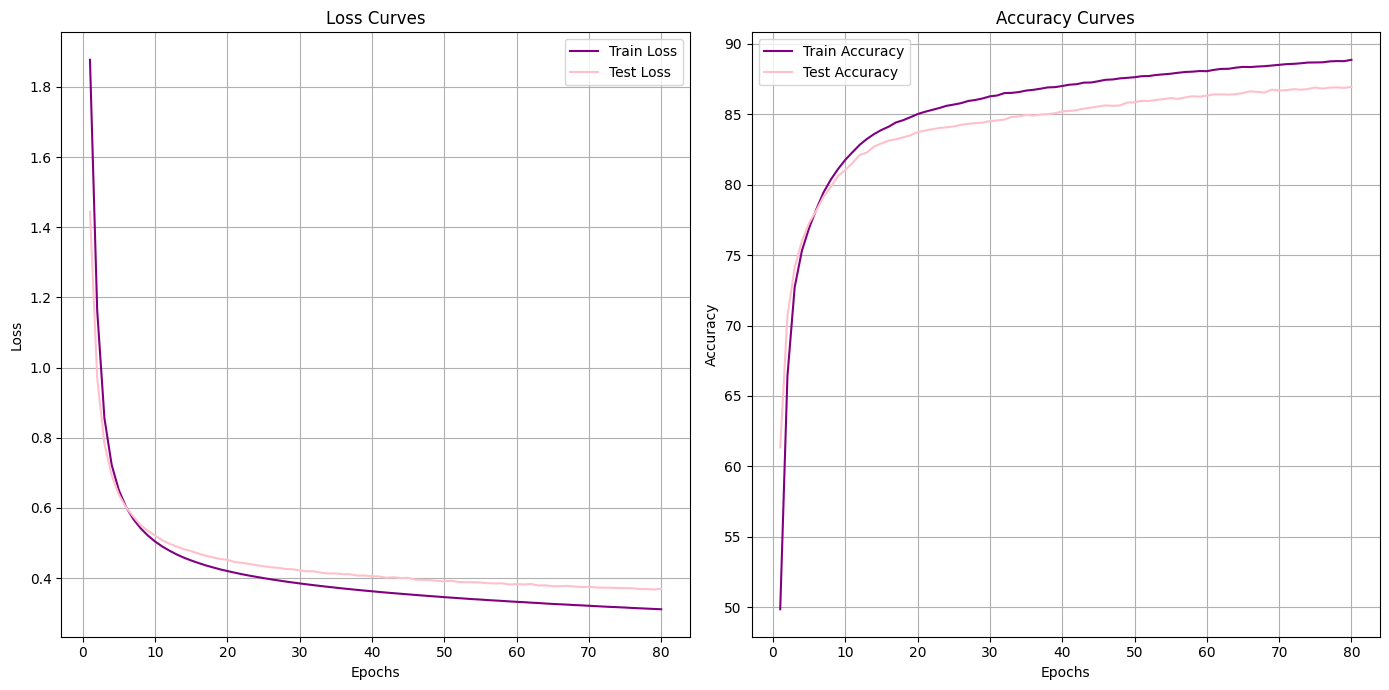

In [26]:
# Standardizarea datelor
scaler = StandardScaler()
x_train_fashion_reshape = scaler.fit_transform(x_train_fashion_flat)
x_test_fashion_reshape = scaler.transform(x_test_fashion_flat)

# Parametri ai arhitecturii și procesului de antrenare
input_size = x_train_fashion_reshape.shape[1]  # Dimensiunea vectorului de intrare
output_size = 10  # FashionMNIST are 10 clase
batch_size = 64
learning_rate = 1e-5
num_epochs = 80

# Configurația dispozitivului (CPU sau GPU)
device = torch.device("cuda")

# Conversia datelor în tensori
x_train_tensor = torch.tensor(x_train_fashion_reshape).float()
y_train_tensor = torch.tensor(y_train_fashion).long()
x_test_tensor = torch.tensor(x_test_fashion_reshape).float()
y_test_tensor = torch.tensor(y_test_fashion).long()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=12)

# Initialize the model, loss function, and optimizer
model = MLP(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model (inputs)
        loss = criterion (outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100* correct_train / total_train)

    # Evaluation Phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion (outputs, targets)
            # Statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')
    
# Final Test Accuracy
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

final_test_accuracy = 100 * correct_test / total_test
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

# Plot the training and testing metrics
print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

In [12]:
import numpy as np
import cv2

x_train_fruits, y_train_fruits = readFruitsInput(fruits, 'Training', dim=64, print_n=True)
x_test_fruits, y_test_fruits = readFruitsInput(fruits, 'Test', dim=64, print_n=True)

# Aplicăm funcția pe seturile de date de antrenare și testare
x_train_fruits_flat = x_train_fruits.reshape(x_train_fruits.shape[0], -1)
x_test_fruits_flat = x_test_fruits.reshape(x_test_fruits.shape[0], -1)


There are 473 TRAINING images of APPLE 6
There are 492 TRAINING images of APPLE BRAEBURN 1
There are 444 TRAINING images of APPLE CRIMSON SNOW 1
There are 480 TRAINING images of APPLE GOLDEN 1
There are 492 TRAINING images of APPLE GOLDEN 2
There are 481 TRAINING images of APPLE GOLDEN 3
There are 492 TRAINING images of APPLE GRANNY SMITH 1
There are 702 TRAINING images of APPLE HIT 1
There are 456 TRAINING images of APPLE PINK LADY 1
There are 492 TRAINING images of APPLE RED 1
There are 492 TRAINING images of APPLE RED 2
There are 429 TRAINING images of APPLE RED 3
There are 490 TRAINING images of APPLE RED DELICIOUS 1
There are 492 TRAINING images of APPLE RED YELLOW 1
There are 672 TRAINING images of APPLE RED YELLOW 2
There are 492 TRAINING images of APRICOT 1
There are 427 TRAINING images of AVOCADO 1
There are 491 TRAINING images of AVOCADO RIPE 1
There are 490 TRAINING images of BANANA 1
There are 450 TRAINING images of BANANA LADY FINGER 1
There are 490 TRAINING images of BANA

Epoch [1/80], Train Loss: 4.2616, Train Accuracy: 13.32%, Test Loss: 3.7612, Test Accuracy: 18.22%
Epoch [2/80], Train Loss: 3.0211, Train Accuracy: 35.03%, Test Loss: 2.7947, Test Accuracy: 38.46%
Epoch [3/80], Train Loss: 2.0577, Train Accuracy: 58.10%, Test Loss: 2.1398, Test Accuracy: 52.00%
Epoch [4/80], Train Loss: 1.4467, Train Accuracy: 71.66%, Test Loss: 1.7506, Test Accuracy: 59.53%
Epoch [5/80], Train Loss: 1.0718, Train Accuracy: 79.27%, Test Loss: 1.5060, Test Accuracy: 64.47%
Epoch [6/80], Train Loss: 0.8211, Train Accuracy: 84.64%, Test Loss: 1.3296, Test Accuracy: 68.27%
Epoch [7/80], Train Loss: 0.6448, Train Accuracy: 88.15%, Test Loss: 1.1969, Test Accuracy: 71.38%
Epoch [8/80], Train Loss: 0.5151, Train Accuracy: 90.81%, Test Loss: 1.0889, Test Accuracy: 73.85%
Epoch [9/80], Train Loss: 0.4167, Train Accuracy: 92.80%, Test Loss: 0.9985, Test Accuracy: 75.44%
Epoch [10/80], Train Loss: 0.3402, Train Accuracy: 94.32%, Test Loss: 0.9285, Test Accuracy: 76.91%
Epoch [11

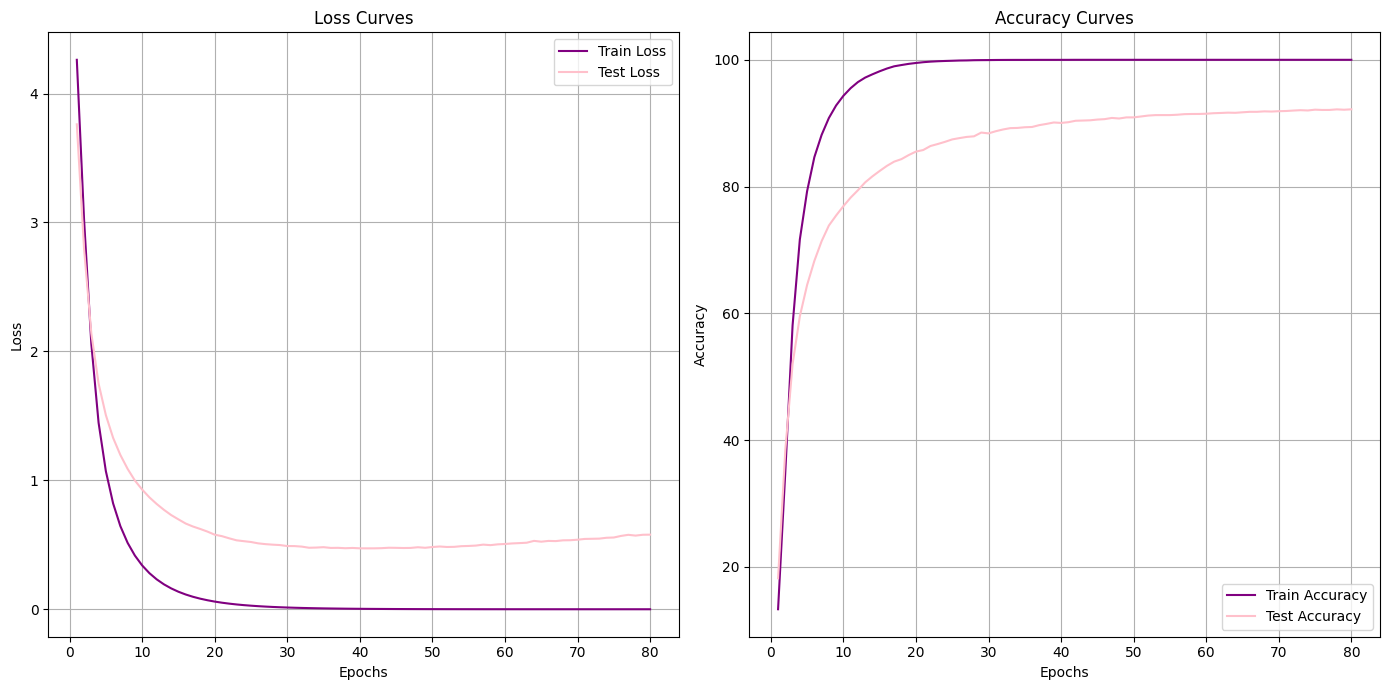

In [14]:
# Import necessary libraries
import torch
from torch.utils.data import TensorDataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Scalarea datelor
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_fruits_flat)
x_test_scaled = scaler.transform(x_test_fruits_flat)

# Parametrii modelului și antrenării
input_size = x_train_fruits_flat.shape[1]  # Dimensiunea vectorului de intrare
output_size = 141  # Numărul de clase
batch_size = 64
learning_rate = 1e-4
num_epochs = 80

# Configurația dispozitivului (CPU sau GPU)
device = torch.device("cuda")

# Conversia datelor în tensori
x_train_tensor = torch.tensor(x_train_scaled).float()
y_train_tensor = torch.tensor(y_train_fruits).long()
x_test_tensor = torch.tensor(x_test_scaled).float()
y_test_tensor = torch.tensor(y_test_fruits).long()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=12)

# Initialize the model, loss function, and optimizer
model = MLP(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        outputs = model (inputs)
        loss = criterion (outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100* correct_train / total_train)

    # Evaluation Phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion (outputs, targets)
            # Statistics
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct_test / total_test)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}%')
    
# Final Test Accuracy
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

final_test_accuracy = 100 * correct_test / total_test
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

# Plot the training and testing metrics
print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

# Cerinta 3

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize

# Define the CNN architecture
class CustomConvNet(nn.Module):
    def __init__(self, num_classes, num_channels, dropout_rate=0.2):
        super(CustomConvNet, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


transforms_with_aug = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomRotation(degrees=5),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

transforms_without_aug = Compose([
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])


Training with augmentations
Epoch [1/80], Train Loss: 2.1422, Train Acc: 33.28%, Test Loss: 1.9919, Test Acc: 46.46%
Epoch [2/80], Train Loss: 1.8838, Train Acc: 42.84%, Test Loss: 1.7600, Test Acc: 48.88%
Epoch [3/80], Train Loss: 1.6822, Train Acc: 45.72%, Test Loss: 1.5690, Test Acc: 54.26%
Epoch [4/80], Train Loss: 1.5184, Train Acc: 49.85%, Test Loss: 1.4185, Test Acc: 58.40%
Epoch [5/80], Train Loss: 1.3884, Train Acc: 54.37%, Test Loss: 1.2973, Test Acc: 62.58%
Epoch [6/80], Train Loss: 1.2864, Train Acc: 57.64%, Test Loss: 1.2031, Test Acc: 67.38%
Epoch [7/80], Train Loss: 1.2030, Train Acc: 60.45%, Test Loss: 1.1223, Test Acc: 69.64%
Epoch [8/80], Train Loss: 1.1330, Train Acc: 62.70%, Test Loss: 1.0535, Test Acc: 72.02%
Epoch [9/80], Train Loss: 1.0765, Train Acc: 64.25%, Test Loss: 1.0000, Test Acc: 71.39%
Epoch [10/80], Train Loss: 1.0251, Train Acc: 66.05%, Test Loss: 0.9510, Test Acc: 72.02%
Epoch [11/80], Train Loss: 0.9822, Train Acc: 67.33%, Test Loss: 0.9051, Test Acc

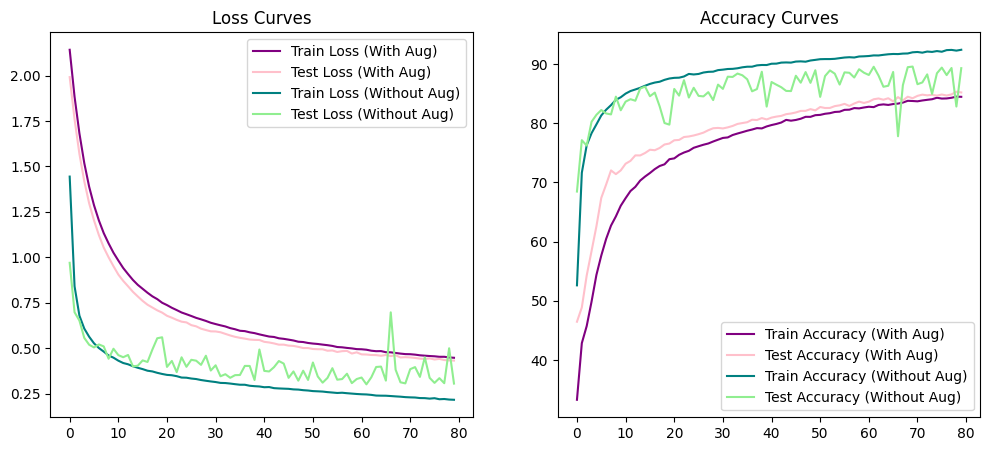

In [6]:
x_train_fashion_tensor = torch.tensor(x_train_fashion).unsqueeze(1) 
x_test_fashion_tensor = torch.tensor(x_test_fashion).unsqueeze(1)

# Dimensiunea reală a datelor după SelectPercentile
input_size = x_train_fashion_tensor.shape[1]  # Actualizăm input_size cu dimensiunea corectă

# Hyperparameters
output_size = 10  # FashionMNIST has 10 classes
batch_size = 64
learning_rate = 1e-5
num_epochs = 80

# Device configuration
device = torch.device("cuda")

# Convert data to tensors
x_train_tensor = x_train_fashion_tensor.clone().detach().float()
y_train_tensor = torch.tensor(y_train_fashion).long()
x_test_tensor = x_test_fashion_tensor.clone().detach().float()
y_test_tensor = torch.tensor(y_test_fashion).long()

train_dataset_with_aug = TensorDataset(x_train_tensor, y_train_tensor)
train_dataset_without_aug = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_with_aug = torch.utils.data.DataLoader(train_dataset_with_aug, batch_size=batch_size, shuffle=True)
train_loader_without_aug = torch.utils.data.DataLoader(train_dataset_without_aug, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Initialize the model, loss function, and optimizer
model = CustomConvNet(output_size, 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses_with_aug, train_losses_without_aug = [], []
test_losses_with_aug, test_losses_without_aug = [], []
train_accs_with_aug, train_accs_without_aug = [], []
test_accs_with_aug, test_accs_without_aug = [], []

print("Training with augmentations")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader_with_aug:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_losses_with_aug.append(train_loss / len(train_loader_with_aug))
    train_accs_with_aug.append(100. * correct_train / total_train)

    # Evaluation phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_losses_with_aug.append(test_loss / len(test_loader))
    test_accs_with_aug.append(100. * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_with_aug[-1]:.4f}, Train Acc: {train_accs_with_aug[-1]:.2f}%, Test Loss: {test_losses_with_aug[-1]:.4f}, Test Acc: {test_accs_with_aug[-1]:.2f}%")

# Reinitialize model and optimizer for training without augmentations
model = CustomConvNet(output_size, 1).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("\nTraining without augmentations")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader_without_aug:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_losses_without_aug.append(train_loss / len(train_loader_without_aug))
    train_accs_without_aug.append(100. * correct_train / total_train)

    # Evaluation phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_losses_without_aug.append(test_loss / len(test_loader))
    test_accs_without_aug.append(100. * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_without_aug[-1]:.4f}, Train Acc: {train_accs_without_aug[-1]:.2f}%, Test Loss: {test_losses_without_aug[-1]:.4f}, Test Acc: {test_accs_without_aug[-1]:.2f}%")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_with_aug, label="Train Loss (With Aug)", color='purple')
plt.plot(test_losses_with_aug, label="Test Loss (With Aug)", color='pink')
plt.plot(train_losses_without_aug, label="Train Loss (Without Aug)", color='teal')
plt.plot(test_losses_without_aug, label="Test Loss (Without Aug)", color='lightgreen')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accs_with_aug, label="Train Accuracy (With Aug)", color='purple')
plt.plot(test_accs_with_aug, label="Test Accuracy (With Aug)", color='pink')
plt.plot(train_accs_without_aug, label="Train Accuracy (Without Aug)", color='teal')
plt.plot(test_accs_without_aug, label="Test Accuracy (Without Aug)", color='lightgreen')
plt.legend()
plt.title("Accuracy Curves")

plt.show()

In [5]:
d = 16
# Citirea datelor în format aplatizat
x_train_fruits_reshape, y_train_fruits_reshape = readFruitsInput(fruits, 'Training', dim  = d, print_n=True)
x_test_fruits_reshape, y_test_fruits_reshape = readFruitsInput(fruits, 'Test', dim = d, print_n=True)

There are 473 TRAINING images of APPLE 6
There are 492 TRAINING images of APPLE BRAEBURN 1
There are 444 TRAINING images of APPLE CRIMSON SNOW 1
There are 480 TRAINING images of APPLE GOLDEN 1
There are 492 TRAINING images of APPLE GOLDEN 2
There are 481 TRAINING images of APPLE GOLDEN 3
There are 492 TRAINING images of APPLE GRANNY SMITH 1
There are 702 TRAINING images of APPLE HIT 1
There are 456 TRAINING images of APPLE PINK LADY 1
There are 492 TRAINING images of APPLE RED 1
There are 492 TRAINING images of APPLE RED 2
There are 429 TRAINING images of APPLE RED 3
There are 490 TRAINING images of APPLE RED DELICIOUS 1
There are 492 TRAINING images of APPLE RED YELLOW 1
There are 672 TRAINING images of APPLE RED YELLOW 2
There are 492 TRAINING images of APRICOT 1
There are 427 TRAINING images of AVOCADO 1
There are 491 TRAINING images of AVOCADO RIPE 1
There are 490 TRAINING images of BANANA 1
There are 450 TRAINING images of BANANA LADY FINGER 1
There are 490 TRAINING images of BANA

Training with augmentations
Epoch [1/80], Train Loss: 3.6397, Train Acc: 17.48%, Test Loss: 2.3860, Test Acc: 47.02%
Epoch [2/80], Train Loss: 1.9753, Train Acc: 45.85%, Test Loss: 1.3347, Test Acc: 75.04%
Epoch [3/80], Train Loss: 1.2744, Train Acc: 63.26%, Test Loss: 0.8493, Test Acc: 83.98%
Epoch [4/80], Train Loss: 0.9087, Train Acc: 73.28%, Test Loss: 0.5997, Test Acc: 87.63%
Epoch [5/80], Train Loss: 0.6880, Train Acc: 79.98%, Test Loss: 0.4704, Test Acc: 89.51%
Epoch [7/80], Train Loss: 0.4350, Train Acc: 87.36%, Test Loss: 0.3091, Test Acc: 92.75%
Epoch [8/80], Train Loss: 0.3624, Train Acc: 89.53%, Test Loss: 0.2598, Test Acc: 94.19%
Epoch [9/80], Train Loss: 0.3046, Train Acc: 91.26%, Test Loss: 0.2356, Test Acc: 94.64%
Epoch [10/80], Train Loss: 0.2623, Train Acc: 92.43%, Test Loss: 0.2239, Test Acc: 94.45%
Epoch [11/80], Train Loss: 0.2237, Train Acc: 93.59%, Test Loss: 0.1908, Test Acc: 94.96%
Epoch [12/80], Train Loss: 0.1953, Train Acc: 94.45%, Test Loss: 0.1650, Test Ac

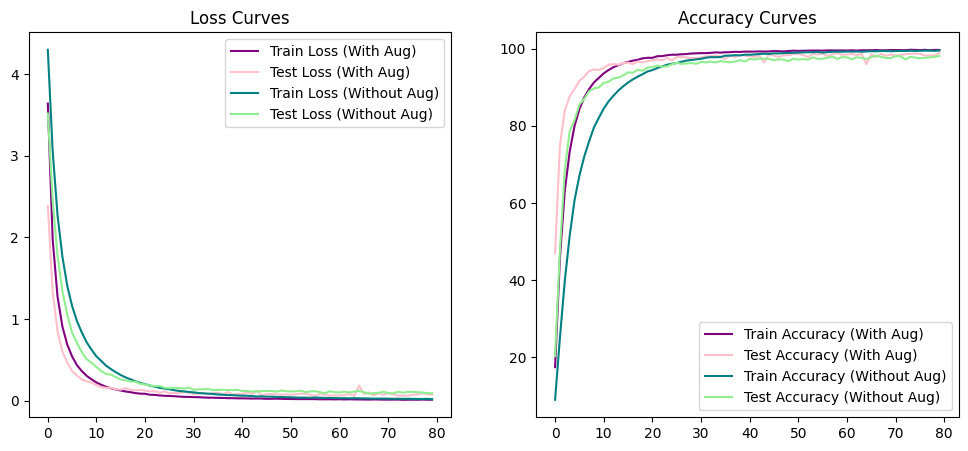

In [8]:

output_size = 141 
batch_size = 64
learning_rate = 1e-4
num_epochs = 80

# Device configuration
device = torch.device("cuda")

# Convert data to tensors
x_train_tensor = torch.tensor(x_train_fruits_reshape).float().permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train_fruits_reshape).long()
x_test_tensor = torch.tensor(x_test_fruits_reshape).float().permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test_fruits_reshape).long()

train_dataset_with_aug = TensorDataset(x_train_tensor, y_train_tensor)
train_dataset_without_aug = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_with_aug = torch.utils.data.DataLoader(train_dataset_with_aug, batch_size=batch_size, shuffle=True)
train_loader_without_aug = torch.utils.data.DataLoader(train_dataset_without_aug, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Initialize the model, loss function, and optimizer
model = CustomConvNet(output_size, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses_with_aug, train_losses_without_aug = [], []
test_losses_with_aug, test_losses_without_aug = [], []
train_accs_with_aug, train_accs_without_aug = [], []
test_accs_with_aug, test_accs_without_aug = [], []

print("Training with augmentations")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader_with_aug:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_losses_with_aug.append(train_loss / len(train_loader_with_aug))
    train_accs_with_aug.append(100. * correct_train / total_train)

    # Evaluation phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_losses_with_aug.append(test_loss / len(test_loader))
    test_accs_with_aug.append(100. * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_with_aug[-1]:.4f}, Train Acc: {train_accs_with_aug[-1]:.2f}%, Test Loss: {test_losses_with_aug[-1]:.4f}, Test Acc: {test_accs_with_aug[-1]:.2f}%")

# Reinitialize model and optimizer for training without augmentations
model = CustomConvNet(output_size, 3).cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

print("\nTraining without augmentations")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, targets in train_loader_without_aug:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_losses_without_aug.append(train_loss / len(train_loader_without_aug))
    train_accs_without_aug.append(100. * correct_train / total_train)

    # Evaluation phase
    model.eval()
    test_loss, correct_test, total_test = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_losses_without_aug.append(test_loss / len(test_loader))
    test_accs_without_aug.append(100. * correct_test / total_test)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses_without_aug[-1]:.4f}, Train Acc: {train_accs_without_aug[-1]:.2f}%, Test Loss: {test_losses_without_aug[-1]:.4f}, Test Acc: {test_accs_without_aug[-1]:.2f}%")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_with_aug, label="Train Loss (With Aug)", color='purple')
plt.plot(test_losses_with_aug, label="Test Loss (With Aug)", color='pink')
plt.plot(train_losses_without_aug, label="Train Loss (Without Aug)", color='teal')
plt.plot(test_losses_without_aug, label="Test Loss (Without Aug)", color='lightgreen')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(train_accs_with_aug, label="Train Accuracy (With Aug)", color='purple')
plt.plot(test_accs_with_aug, label="Test Accuracy (With Aug)", color='pink')
plt.plot(train_accs_without_aug, label="Train Accuracy (Without Aug)", color='teal')
plt.plot(test_accs_without_aug, label="Test Accuracy (Without Aug)", color='lightgreen')
plt.legend()
plt.title("Accuracy Curves")

plt.show()

# Cerinta 4

In [10]:
d = 32
# Citirea datelor în format aplatizat
x_train_fruits_reshape, y_train_fruits_reshape = readFruitsInput(fruits, 'Training', dim  = d, print_n=True)
x_test_fruits_reshape, y_test_fruits_reshape = readFruitsInput(fruits, 'Test', dim = d, print_n=True)


There are 473 TRAINING images of APPLE 6
There are 492 TRAINING images of APPLE BRAEBURN 1
There are 444 TRAINING images of APPLE CRIMSON SNOW 1
There are 480 TRAINING images of APPLE GOLDEN 1
There are 492 TRAINING images of APPLE GOLDEN 2
There are 481 TRAINING images of APPLE GOLDEN 3
There are 492 TRAINING images of APPLE GRANNY SMITH 1
There are 702 TRAINING images of APPLE HIT 1
There are 456 TRAINING images of APPLE PINK LADY 1
There are 492 TRAINING images of APPLE RED 1
There are 492 TRAINING images of APPLE RED 2
There are 429 TRAINING images of APPLE RED 3
There are 490 TRAINING images of APPLE RED DELICIOUS 1
There are 492 TRAINING images of APPLE RED YELLOW 1
There are 672 TRAINING images of APPLE RED YELLOW 2
There are 492 TRAINING images of APRICOT 1
There are 427 TRAINING images of AVOCADO 1
There are 491 TRAINING images of AVOCADO RIPE 1
There are 490 TRAINING images of BANANA 1
There are 450 TRAINING images of BANANA LADY FINGER 1
There are 490 TRAINING images of BANA

Epoch 1/80
Train Loss: 4.3787, Train Acc: 16.60%
Test Loss: 3.8354, Test Acc: 29.42%
Epoch 2/80
Train Loss: 3.2168, Train Acc: 47.54%
Test Loss: 2.8125, Test Acc: 53.17%
Epoch 3/80
Train Loss: 2.2478, Train Acc: 69.56%
Test Loss: 2.0138, Test Acc: 69.36%
Epoch 4/80
Train Loss: 1.5548, Train Acc: 81.42%
Test Loss: 1.4954, Test Acc: 77.74%
Epoch 5/80
Train Loss: 1.0977, Train Acc: 87.91%
Test Loss: 1.1536, Test Acc: 82.18%
Epoch 6/80
Train Loss: 0.7955, Train Acc: 91.71%
Test Loss: 0.9256, Test Acc: 85.76%
Epoch 7/80
Train Loss: 0.6011, Train Acc: 94.16%
Test Loss: 0.7733, Test Acc: 87.50%
Epoch 8/80
Train Loss: 0.5162, Train Acc: 95.25%
Test Loss: 0.7599, Test Acc: 87.40%
Epoch 9/80
Train Loss: 0.5030, Train Acc: 95.43%
Test Loss: 0.7416, Test Acc: 87.90%
Epoch 10/80
Train Loss: 0.4903, Train Acc: 95.69%
Test Loss: 0.7307, Test Acc: 87.92%
Epoch 11/80
Train Loss: 0.4761, Train Acc: 95.82%
Test Loss: 0.7164, Test Acc: 88.22%
Epoch 12/80
Train Loss: 0.4665, Train Acc: 95.89%
Test Loss: 0.

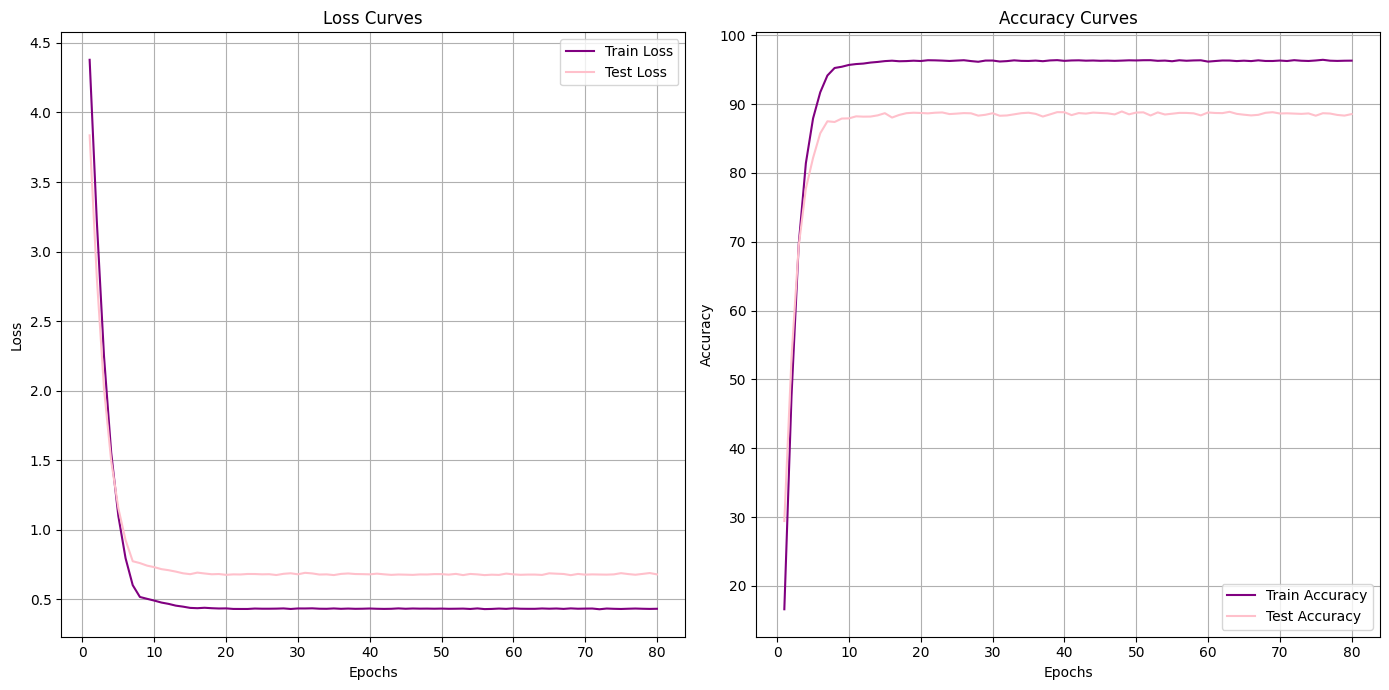

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from cifar10_models.resnet import resnet18

# Configurații
batch_size = 64
learning_rate = 1e-4
num_epochs = 80
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1

# Transformări pentru Fruits-360
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),  # Redimensionare la 32x32
        transforms.RandomHorizontalFlip(),  # Augmentare
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizare
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),  # Redimensionare la 32x32
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizare
    ]),
}

# Aplicarea transformărilor pentru setul de date Fruits-360
x_train_fruits_reshape = x_train_fruits_reshape.reshape(-1, 32, 32, 3)
x_test_fruits_reshape = x_test_fruits_reshape.reshape(-1, 32, 32, 3)

train_images = [data_transforms['train'](img) for img in x_train_fruits_reshape]
test_images = [data_transforms['val'](img) for img in x_test_fruits_reshape]

# Convertirea listelor în tensori
x_train_tensor = torch.stack(train_images)
x_test_tensor = torch.stack(test_images)
y_train_tensor = torch.tensor(y_train_fruits_reshape).long()
y_test_tensor = torch.tensor(y_test_fruits_reshape).long()

# Crearea dataset-urilor și a DataLoader-urilor
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda")

# Încărcarea modelului ResNet-18 pre-antrenat
model = resnet18(pretrained=False) 
model.fc = nn.Linear(model.fc.in_features, 141) 
model = model.to(device)

# Definirea funcției de pierdere și a optimizatorului
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Funcția de antrenare și validare
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Bucla principală de antrenare
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%") 

print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs) 

Epoch 1/80
Train Loss: 0.9973, Train Acc: 67.85%
Val Loss: 0.6422, Val Acc: 78.20%
Epoch 2/80
Train Loss: 0.5468, Train Acc: 81.08%
Val Loss: 0.5193, Val Acc: 81.61%
Epoch 3/80
Train Loss: 0.4554, Train Acc: 83.91%
Val Loss: 0.4708, Val Acc: 83.04%
Epoch 4/80
Train Loss: 0.4048, Train Acc: 85.59%
Val Loss: 0.4425, Val Acc: 84.02%
Epoch 5/80
Train Loss: 0.3712, Train Acc: 86.72%
Val Loss: 0.4226, Val Acc: 84.90%
Epoch 6/80
Train Loss: 0.3434, Train Acc: 87.79%
Val Loss: 0.4115, Val Acc: 84.91%
Epoch 7/80
Train Loss: 0.3219, Train Acc: 88.38%
Val Loss: 0.4014, Val Acc: 85.15%
Epoch 8/80
Train Loss: 0.2943, Train Acc: 89.59%
Val Loss: 0.3994, Val Acc: 85.26%
Epoch 9/80
Train Loss: 0.2905, Train Acc: 89.73%
Val Loss: 0.3972, Val Acc: 85.30%
Epoch 10/80
Train Loss: 0.2888, Train Acc: 89.91%
Val Loss: 0.3969, Val Acc: 85.38%
Epoch 11/80
Train Loss: 0.2854, Train Acc: 89.89%
Val Loss: 0.3956, Val Acc: 85.64%
Epoch 12/80
Train Loss: 0.2842, Train Acc: 90.09%
Val Loss: 0.3955, Val Acc: 85.38%
E

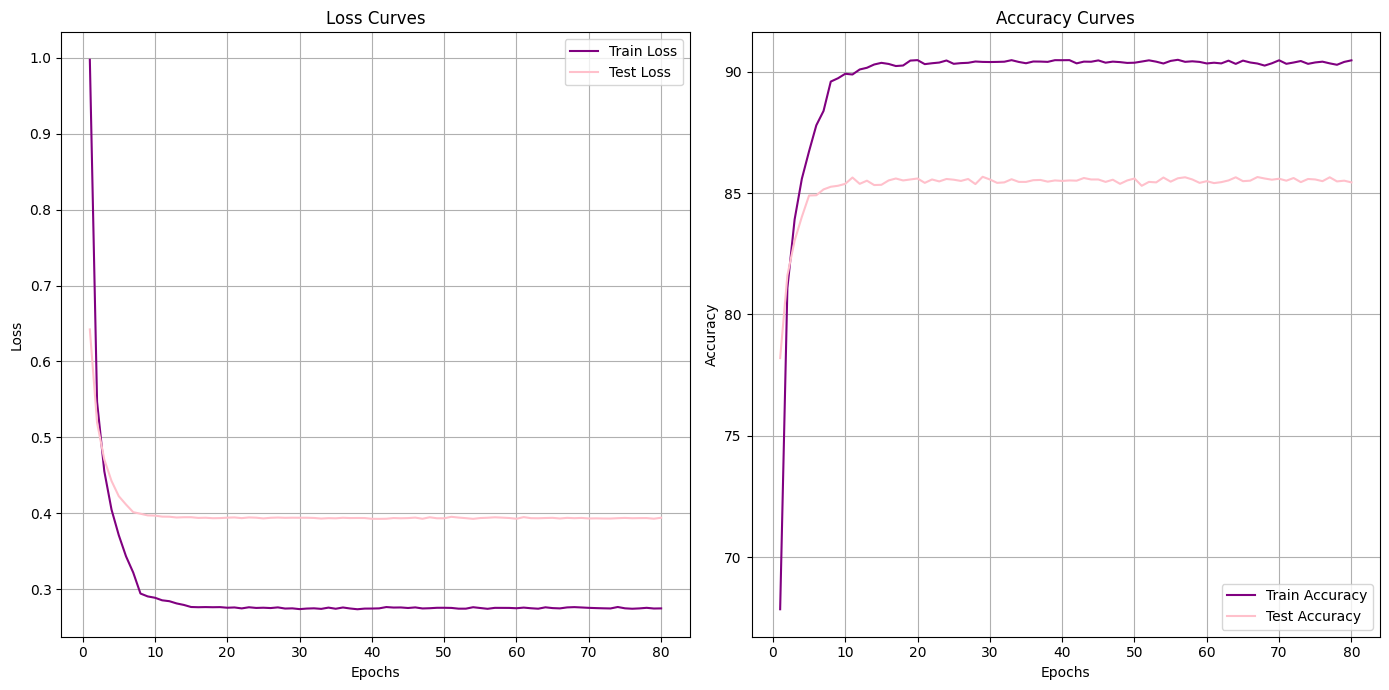

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Hyperparameters
output_size = 10  # FashionMNIST has 10 classes
batch_size = 128
learning_rate = 1e-4
num_epochs = 80
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure 3 channels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Apply transformations to training data
x_train_transformed = torch.stack([data_transforms['train'](img) for img in x_train_fashion])
x_test_transformed = torch.stack([data_transforms['val'](img) for img in x_test_fashion])

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train_fashion).long()
y_test_tensor = torch.tensor(y_test_fashion).long()

# Create TensorDataset
train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Încărcarea modelului pre-antrenat
model = models.resnet18(pretrained=False) 
model.fc = nn.Linear(model.fc.in_features, output_size) 
device = torch.device("cuda")
model = model.to(device)

# Definirea funcției de pierdere și a optimizatorului
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Funcția de antrenare și validare
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Bucla principală de antrenare
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%") 

print_plt(train_losses, test_losses, train_accuracies, test_accuracies, num_epochs)

# Comparatii


In [6]:
fashion_labels_map = {
    0: "T-shirt/Top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}

path = os.path.join(path2, "Training")
fruits_class_names = sorted(os.listdir(path))

## Task 1

Fruits  

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=fruits_class_names, digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

                       precision    recall  f1-score   support

              Apple 6     0.7044    0.7134    0.7089       157
     Apple Braeburn 1     0.7895    0.1829    0.2970       164
 Apple Crimson Snow 1     0.0698    0.0203    0.0314       148
       Apple Golden 1     0.7880    0.9062    0.8430       160
       Apple Golden 2     0.6822    0.9817    0.8050       164
       Apple Golden 3     0.5610    0.2857    0.3786       161
 Apple Granny Smith 1     0.9487    0.4512    0.6116       164
    Apple Pink Lady 1     0.5987    0.8034    0.6861       234
          Apple Red 1     0.2841    0.1645    0.2083       152
          Apple Red 2     0.1720    0.0976    0.1245       164
          Apple Red 3     0.7262    0.3720    0.4919       164
Apple Red Delicious 1     0.3431    0.5694    0.4282       144
   Apple Red Yellow 1     0.3376    0.4819    0.3970       166
   Apple Red Yellow 2     0.4641    0.5915    0.5201       164
          Apple hit 1     0.9

Fashion

In [27]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=list(fashion_labels_map.values()), digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

              precision    recall  f1-score   support

 T-shirt/Top     0.7463    0.8120    0.7778      1000
     Trouser     0.9335    0.9260    0.9297      1000
    Pullover     0.6229    0.6790    0.6498      1000
       Dress     0.7812    0.8140    0.7973      1000
        Coat     0.6591    0.6710    0.6650      1000
      Sandal     0.9135    0.8870    0.9001      1000
       Shirt     0.5040    0.3810    0.4339      1000
     Sneaker     0.8719    0.8920    0.8819      1000
         Bag     0.9334    0.9390    0.9362      1000
  Ankle Boot     0.9221    0.9350    0.9285      1000

    accuracy                         0.7936     10000
   macro avg     0.7888    0.7936    0.7900     10000
weighted avg     0.7888    0.7936    0.7900     10000



## Task 2

Fashion

In [11]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=list(fashion_labels_map.values()), digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

              precision    recall  f1-score   support

 T-shirt/Top     0.8377    0.8360    0.8368      1000
     Trouser     0.9807    0.9660    0.9733      1000
    Pullover     0.7986    0.7970    0.7978      1000
       Dress     0.8502    0.8910    0.8701      1000
        Coat     0.7854    0.8090    0.7970      1000
      Sandal     0.9650    0.9370    0.9508      1000
       Shirt     0.7068    0.6630    0.6842      1000
     Sneaker     0.9224    0.9510    0.9365      1000
         Bag     0.9718    0.9650    0.9684      1000
  Ankle Boot     0.9444    0.9520    0.9482      1000

    accuracy                         0.8767     10000
   macro avg     0.8763    0.8767    0.8763     10000
weighted avg     0.8763    0.8767    0.8763     10000



Fruits

In [14]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=fruits_class_names, digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

                       precision    recall  f1-score   support

              Apple 6     0.9401    1.0000    0.9691       157
     Apple Braeburn 1     0.7595    0.7317    0.7453       164
 Apple Crimson Snow 1     0.7500    0.9527    0.8393       148
       Apple Golden 1     0.8377    1.0000    0.9117       160
       Apple Golden 2     0.9787    0.8415    0.9049       164
       Apple Golden 3     0.7318    1.0000    0.8451       161
 Apple Granny Smith 1     1.0000    0.6951    0.8201       164
    Apple Pink Lady 1     1.0000    1.0000    1.0000       234
          Apple Red 1     0.8657    0.7632    0.8112       152
          Apple Red 2     0.8990    0.5427    0.6768       164
          Apple Red 3     0.9686    0.9390    0.9536       164
Apple Red Delicious 1     0.9820    0.7569    0.8549       144
   Apple Red Yellow 1     1.0000    0.6386    0.7794       166
   Apple Red Yellow 2     0.8956    0.9939    0.9422       164
          Apple hit 1     0.9

## Task 3

Fashion

In [13]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model with augmentations
print("\nEvaluating the model trained with augmentations")
model.eval()
y_true_with_aug, y_pred_with_aug = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_with_aug.extend(targets.cpu().numpy())
        y_pred_with_aug.extend(predicted.cpu().numpy())

# Compute metrics for the model trained with augmentations
precision_with_aug, recall_with_aug, f1_score_with_aug, _ = precision_recall_fscore_support(
    y_true_with_aug, y_pred_with_aug, average="weighted", zero_division=0
)

class_report_with_aug = classification_report(
    y_true_with_aug, y_pred_with_aug, target_names=list(fashion_labels_map.values()), digits=4, zero_division=0
)

print("\nClassification Report (With Augmentations):\n")
print(class_report_with_aug)

# Reinitialize model and optimizer for training without augmentations
model = CustomConvNet(output_size, 3).to(torch.device("cuda"))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model without augmentations
print("\nTraining without augmentations")
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader_without_aug:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model without augmentations
print("\nEvaluating the model trained without augmentations")
y_true_without_aug, y_pred_without_aug = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_without_aug.extend(targets.cpu().numpy())
        y_pred_without_aug.extend(predicted.cpu().numpy())

# Compute metrics for the model trained without augmentations
precision_without_aug, recall_without_aug, f1_score_without_aug, _ = precision_recall_fscore_support(
    y_true_without_aug, y_pred_without_aug, average="weighted", zero_division=0
)

class_report_without_aug = classification_report(
    y_true_without_aug, y_pred_without_aug, target_names=list(fashion_labels_map.values()), digits=4, zero_division=0
)

print("\nClassification Report (Without Augmentations):\n")
print(class_report_without_aug)

# Combine results from both models
print("\nCombined Results:")
print(f"Precision (With Aug): {precision_with_aug:.4f}, Without Aug: {precision_without_aug:.4f}")
print(f"Recall (With Aug): {recall_with_aug:.4f}, Without Aug: {recall_without_aug:.4f}")
print(f"F1 Score (With Aug): {f1_score_with_aug:.4f}, Without Aug: {f1_score_without_aug:.4f}")


Evaluating the model trained with augmentations

Classification Report (With Augmentations):

              precision    recall  f1-score   support

 T-shirt/Top     0.8657    0.7480    0.8026      1000
     Trouser     0.9849    0.9810    0.9830      1000
    Pullover     0.7289    0.9140    0.8110      1000
       Dress     0.8429    0.8100    0.8261      1000
        Coat     0.5800    0.9280    0.7138      1000
      Sandal     0.9953    0.8500    0.9169      1000
       Shirt     0.9038    0.3100    0.4617      1000
     Sneaker     0.8956    0.9610    0.9272      1000
         Bag     0.9876    0.9530    0.9700      1000
  Ankle Boot     0.8908    0.9710    0.9292      1000

    accuracy                         0.8426     10000
   macro avg     0.8676    0.8426    0.8341     10000
weighted avg     0.8676    0.8426    0.8341     10000


Training without augmentations

Evaluating the model trained without augmentations

Classification Report (Without Augmentations):

             

In [9]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

model = CustomConvNet(output_size, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model with augmentations
print("\nTraining with augmentations")
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader_with_aug:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model with augmentations
print("\nEvaluating the model trained with augmentations")
y_true_with_aug, y_pred_with_aug = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_with_aug.extend(targets.cpu().numpy())
        y_pred_with_aug.extend(predicted.cpu().numpy())

# Compute metrics for the model trained with augmentations
precision_with_aug, recall_with_aug, f1_score_with_aug, _ = precision_recall_fscore_support(
    y_true_with_aug, y_pred_with_aug, average="weighted", zero_division=0
)

class_report_with_aug = classification_report(
    y_true_with_aug, y_pred_with_aug, target_names=fruits_class_names, digits=4, zero_division=0
)

print("\nClassification Report (With Augmentations):\n")
print(class_report_with_aug)

model = CustomConvNet(output_size, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model without augmentations
print("\nTraining without augmentations")
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader_without_aug:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model without augmentations
print("\nEvaluating the model trained without augmentations")
y_true_without_aug, y_pred_without_aug = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(torch.device("cuda")), targets.to(torch.device("cuda"))
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true_without_aug.extend(targets.cpu().numpy())
        y_pred_without_aug.extend(predicted.cpu().numpy())

# Compute metrics for the model trained without augmentations
precision_without_aug, recall_without_aug, f1_score_without_aug, _ = precision_recall_fscore_support(
    y_true_without_aug, y_pred_without_aug, average="weighted", zero_division=0
)

class_report_without_aug = classification_report(
    y_true_without_aug, y_pred_without_aug, target_names=fruits_class_names, digits=4, zero_division=0
)

print("\nClassification Report (Without Augmentations):\n")
print(class_report_without_aug)

# Combine results from both models
print("\nCombined Results:")
print(f"Precision (With Aug): {precision_with_aug:.4f}, Without Aug: {precision_without_aug:.4f}")
print(f"Recall (With Aug): {recall_with_aug:.4f}, Without Aug: {recall_without_aug:.4f}")
print(f"F1 Score (With Aug): {f1_score_with_aug:.4f}, Without Aug: {f1_score_without_aug:.4f}")


Training with augmentations

Evaluating the model trained with augmentations

Classification Report (With Augmentations):

                       precision    recall  f1-score   support

              Apple 6     0.9691    1.0000    0.9843       157
     Apple Braeburn 1     0.9320    0.8354    0.8810       164
 Apple Crimson Snow 1     0.9500    0.8986    0.9236       148
       Apple Golden 1     0.9748    0.9688    0.9718       160
       Apple Golden 2     0.9879    0.9939    0.9909       164
       Apple Golden 3     0.9699    1.0000    0.9847       161
 Apple Granny Smith 1     1.0000    0.9939    0.9969       164
    Apple Pink Lady 1     0.9915    1.0000    0.9957       234
          Apple Red 1     0.7874    0.9013    0.8405       152
          Apple Red 2     0.9747    0.9390    0.9565       164
          Apple Red 3     0.9879    0.9939    0.9909       164
Apple Red Delicious 1     0.9156    0.9792    0.9463       144
   Apple Red Yellow 1     1.0000    0.9940    0.9970    

## Task 4

Fashion

In [8]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=list(fashion_labels_map.values()), digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

              precision    recall  f1-score   support

 T-shirt/Top     0.7800    0.8050    0.7923      1000
     Trouser     0.9928    0.9600    0.9761      1000
    Pullover     0.7792    0.7730    0.7761      1000
       Dress     0.8518    0.8910    0.8710      1000
        Coat     0.7817    0.7880    0.7849      1000
      Sandal     0.9439    0.9420    0.9429      1000
       Shirt     0.6528    0.6110    0.6312      1000
     Sneaker     0.9213    0.9250    0.9232      1000
         Bag     0.9474    0.9550    0.9512      1000
  Ankle Boot     0.9336    0.9420    0.9378      1000

    accuracy                         0.8592     10000
   macro avg     0.8585    0.8592    0.8587     10000
weighted avg     0.8585    0.8592    0.8587     10000



Fruits

In [12]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

# Evaluate the model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
precision, recall, f1_score, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

# Generate class-wise metrics and display them
class_report = classification_report(
    y_true, y_pred, target_names=fruits_class_names, digits=4, zero_division=0
)

# Display the class-wise metrics
print("\nClassification Report:\n")
print(class_report)



Classification Report:

                       precision    recall  f1-score   support

              Apple 6     0.7212    0.9554    0.8219       157
     Apple Braeburn 1     0.8592    0.7439    0.7974       164
 Apple Crimson Snow 1     0.7554    0.9392    0.8373       148
       Apple Golden 1     0.9877    1.0000    0.9938       160
       Apple Golden 2     0.8410    1.0000    0.9136       164
       Apple Golden 3     0.7430    0.9876    0.8480       161
 Apple Granny Smith 1     0.9760    0.9939    0.9849       164
    Apple Pink Lady 1     0.7312    1.0000    0.8448       234
          Apple Red 1     0.6542    0.4605    0.5405       152
          Apple Red 2     0.6936    0.9939    0.8170       164
          Apple Red 3     0.9310    0.9878    0.9586       164
Apple Red Delicious 1     0.7337    0.9375    0.8232       144
   Apple Red Yellow 1     1.0000    0.8735    0.9325       166
   Apple Red Yellow 2     1.0000    0.8841    0.9385       164
          Apple hit 1     0.9